In [1]:
# digit recognizer 0 to 9 using mnist Dataset

In [66]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time

In [3]:
# MNIST = datasets.mnist('data.csvmnist_trainset')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

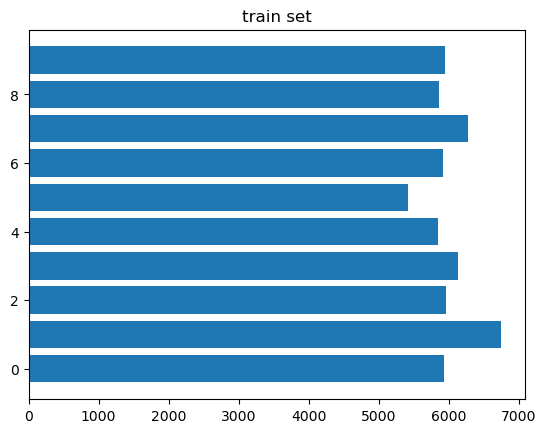

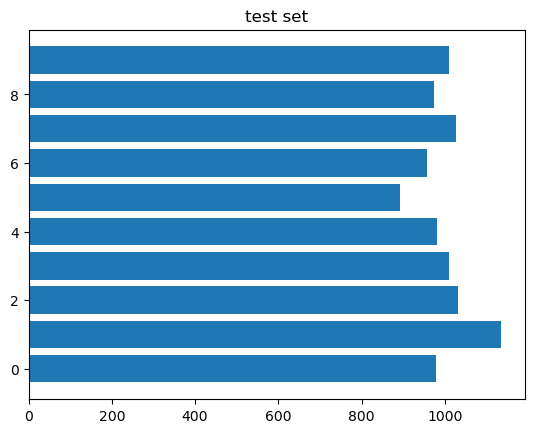

In [4]:
train_count = np.unique(mnist_trainset.targets.numpy(), return_counts=True)
test_count = np.unique(mnist_testset.targets.numpy(), return_counts=True)

plt.barh(y=train_count[0], width=train_count[1])
plt.title('train set')
plt.show()

plt.barh(y=test_count[0], width=test_count[1])
plt.title('test set')
plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
X_train = mnist_trainset.data.to(device)
X_train = X_train.float()

y_train = mnist_trainset.targets.to(device)

X_test = mnist_testset.data.to(device)
X_test = X_test.float()

y_test = mnist_testset.targets.to(device)

X_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

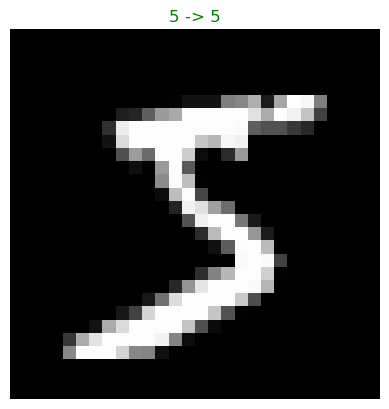

In [82]:
def show_img(X: torch.Tensor, y: torch.Tensor, pred: torch.Tensor):
    X = torch.Tensor.cpu(X).reshape(-1, 28, 28, 1)
    y = torch.Tensor.cpu(y).reshape(-1, 1)
    pred = torch.Tensor.cpu(pred).reshape(-1, 1)
    rows = columns = math.ceil(X.size(dim=0)**0.5)
    fig, axs = plt.subplots(rows, columns)
    for i in range(X.size(dim=0)):
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(X[i] , cmap='grey')
        plt.title(f'{y[i].item()} -> {pred[i].item()}', color=('red' if y[i].item()!=pred[i].item() else 'green'))
    plt.show()

show_img(X_train[0], y_train[0], y_train[0])

In [8]:
class Model1(nn.Module): # without convolution layers
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        output = input.view(-1, 28*28)
        output = self.l1(output)
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [9]:
class Model2(nn.Module): # using CNN's 
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        input = input.view(-1, 1, 28, 28)
        # size = X * 28*28 * 1
        
        output = self.relu(self.pool(self.conv1(input)))
        # size = X * 12*12 * 6
        output = self.relu(self.pool(self.conv2(output)))
        # size = X * 4*4 * 16
        
        output = output.view(-1, 16 * 4*4) # flattening
        # size = X * 256

        output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        
        output = self.dropout(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [10]:
def train(model: nn.Module, epochs: int, learning_rate: float) -> nn.Module:
    print(model.parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    for i in range(epochs):
        pred = model(X_train)
        loss = criterion(pred, y_train)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i % (epochs//10)==0):
            with torch.no_grad():
                pred_test = model(X_test)
                pred_test = torch.argmax(pred_test, dim=1)
            
                correct = (pred_test==y_test).sum().item()
                acc = 100 * (correct/y_test.size(dim=0))
                print(f'epoch = {i}/{epochs}')
                print(f'loss = {loss.item():.3f}')
                print(f'accuracy = {acc:.3f}', end=2*'\n')

    
    with torch.no_grad(): # not using evaluation(test) for gradient descent
        pred_test = model(X_test)
        pred_test = torch.argmax(pred_test, dim=1)
    
        correct = (pred_test==y_test).sum().item()
        acc = 100 * (correct/y_test.size(dim=0))
        print(f'epoch = {i+1}/{epochs}')
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2*'\n')
        
    end_time = time.time()
    print(f'total {end_time-start_time:.3f} seconds on {device}.')
    return model

In [90]:
epochs = 200
learning_rate = 0.0005

model1 = Model1(28*28, 40, 20).to(device)
model2 = Model2(4*4*16, 120, 80).to(device)

print("model 1")
train(model1, epochs=epochs, learning_rate=learning_rate)

print('\n'*5)

print("model 2")
model = train(model2, epochs=epochs, learning_rate=learning_rate) # saving trained conv-model

model 1
<bound method Module.parameters of Model1(
  (l1): Linear(in_features=784, out_features=40, bias=True)
  (l2): Linear(in_features=40, out_features=20, bias=True)
  (l3): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)>
epoch = 0/200
loss = 2.394
accuracy = 13.460

epoch = 20/200
loss = 1.821
accuracy = 50.310

epoch = 40/200
loss = 1.707
accuracy = 64.190

epoch = 60/200
loss = 1.598
accuracy = 76.000

epoch = 80/200
loss = 1.566
accuracy = 79.550

epoch = 100/200
loss = 1.551
accuracy = 82.320

epoch = 120/200
loss = 1.541
accuracy = 87.160

epoch = 140/200
loss = 1.527
accuracy = 91.280

epoch = 160/200
loss = 1.519
accuracy = 92.720

epoch = 180/200
loss = 1.514
accuracy = 93.280

epoch = 200/200
loss = 1.510
accuracy = 93.750

total 10.439 seconds on cuda.






model 2
<bound method Module.parameters of Model2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (p

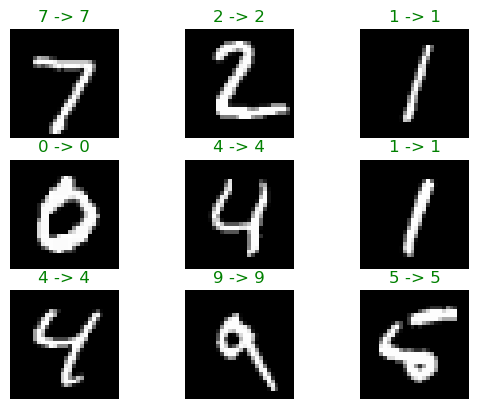

In [94]:
pred_test = model(X_test)
pred_test = torch.argmax(pred_test, dim=1)

sample_size = 9
show_img(X_test[:sample_size], y_test[:sample_size],pred_test[:sample_size])

Wrong predicts : 392/10000


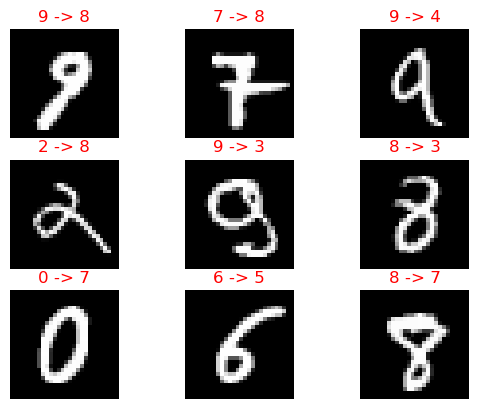

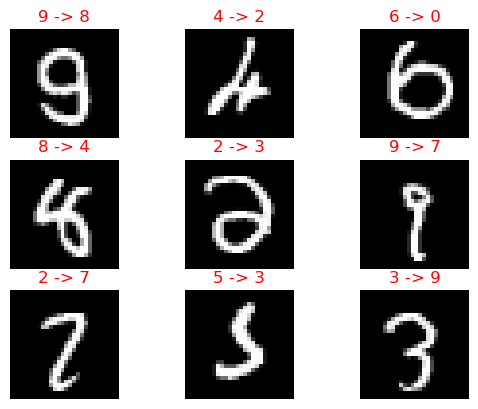

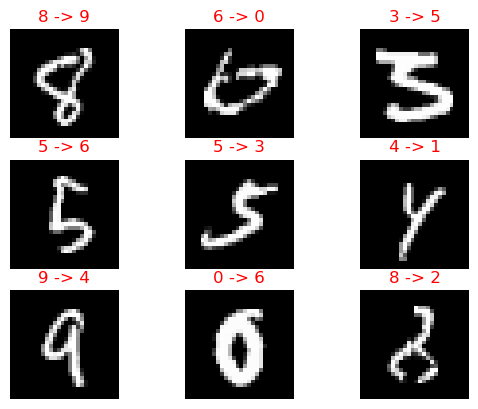

In [98]:
wrong_pred_index = (pred_test!=y_test)
wrong_preds = (X_test[wrong_pred_index], y_test[wrong_pred_index], pred_test[wrong_pred_index])
print(f'Wrong predicts : {wrong_preds[0].size(dim=0)}/{X_test.size(dim=0)}')
for i in range(0, 9*3, 9): # 10 instances which the model predicted wrongly
    show_img(wrong_preds[0][i:i+9], wrong_preds[1][i:i+9], wrong_preds[2][i:i+9])

# show_img(wrong_preds[0][i], wrong_preds[1][i], wrong_preds[2][i])